# MPC SHELL Driving Style Optimization

## Conenct to VM

### 1. SSH into the VM

Open PowerShell or your terminal and run:

```bash
ssh student@10.125.85.10
```


### 2. Start Jupyter Notebook on the VM

Inside the VM, run:

```bash
source notebook-env/bin/activate
jupyter notebook --no-browser --ip=0.0.0.0 --port=8888
```

### 3. Create an SSH Tunnel from Your Laptop

Open **a second** terminal on your laptop and run:

```bash
ssh -L 8888:localhost:8888 student@10.125.85.10
```


In [ ]:
!nvidia-smi

Sat Nov 15 04:58:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   56C    P0             32W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Track: Loading and visualizing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class Track:
    s_m: np.ndarray
    x_m: np.ndarray
    y_m: np.ndarray
    lat_deg: np.ndarray
    lon_deg: np.ndarray
    altitude_m: np.ndarray
    heading_rad: np.ndarray
    grade: np.ndarray
    curvature: np.ndarray
    length_m: float


def load_track_from_csv(
    file_path="sem_apme_2025-track_coordinates.csv"
) -> Track:

    df = pd.read_csv(file_path, sep="\t")

    lat = df["latitude"].to_numpy(float)
    lon = df["longitude"].to_numpy(float)
    alt = df["altitude (m)"].to_numpy(float)
    s_km = df["distance (km)"].to_numpy(float)

    # distance in meters
    s_m = s_km * 1000.0

    # convert lat/lon to local x,y in meters
    R = 6371000.0
    lat0 = np.deg2rad(lat[0])
    lon0 = np.deg2rad(lon[0])

    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)

    dlat = lat_rad - lat0
    dlon = lon_rad - lon0

    x_m = R * np.cos(lat0) * dlon
    y_m = R * dlat

    # compute heading
    dx = np.diff(x_m)
    dy = np.diff(y_m)
    segment_heading = np.arctan2(dy, dx)  # N-1

    heading = np.zeros_like(lat)
    heading[0] = segment_heading[0]
    heading[-1] = segment_heading[-1]

    if len(segment_heading) > 1:
        heading[1:-1] = 0.5 * (segment_heading[:-1] + segment_heading[1:])
    else:
        heading[1:-1] = segment_heading[0]

    # slope / grade
    ds = np.diff(s_m)
    dalt = np.diff(alt)

    ds_safe = np.where(np.abs(ds) < 1e-6, 1e-6, ds)  # avoid division by zero
    grade_seg = dalt / ds_safe  # N-1

    grade = np.zeros_like(alt)
    grade[0] = grade_seg[0]
    grade[-1] = grade_seg[-1]
    if len(grade_seg) > 1:
        grade[1:-1] = 0.5 * (grade_seg[:-1] + grade_seg[1:])
    else:
        grade[1:-1] = grade_seg[0]

    # curvature (✔ fixed)
    dheading = np.diff(heading)   # N-1
    curvature_seg = dheading / ds_safe  # N-1

    curvature = np.zeros_like(heading)
    curvature[0] = curvature_seg[0]
    curvature[-1] = curvature_seg[-1]
    if len(curvature_seg) > 1:
        curvature[1:-1] = 0.5 * (curvature_seg[:-1] + curvature_seg[1:])
    else:
        curvature[1:-1] = curvature_seg[0]

    length_m = float(s_m[-1] - s_m[0])

    return Track(
        s_m=s_m,
        x_m=x_m,
        y_m=y_m,
        lat_deg=lat,
        lon_deg=lon,
        altitude_m=alt,
        heading_rad=heading,
        grade=grade,
        curvature=curvature,
        length_m=length_m,
    )

def get_track_props(track, s):
    """
    Returns interpolated track centerline properties at distance s:
    x_ref, y_ref, heading_ref, curvature, slope
    """
    # wrap around track (loop)
    s = s % track.length_m

    x = np.interp(s, track.s_m, track.x_m)
    y = np.interp(s, track.s_m, track.y_m)
    heading = np.interp(s, track.s_m, track.heading_rad)
    curvature = np.interp(s, track.s_m, track.curvature)
    grade = np.interp(s, track.s_m, track.grade)

    return x, y, heading, curvature, grade


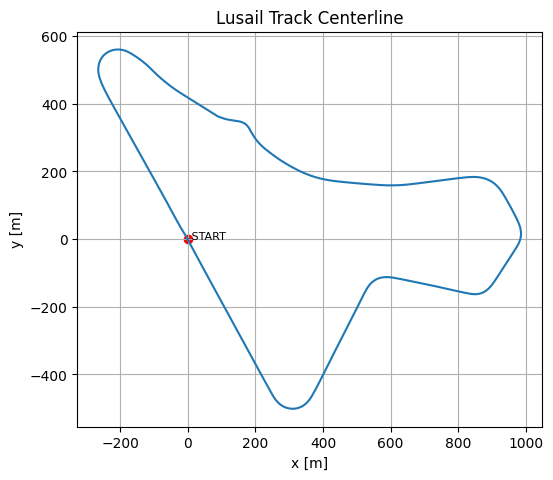

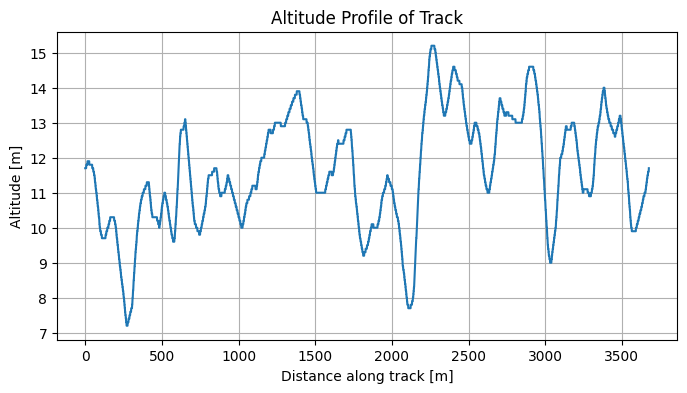

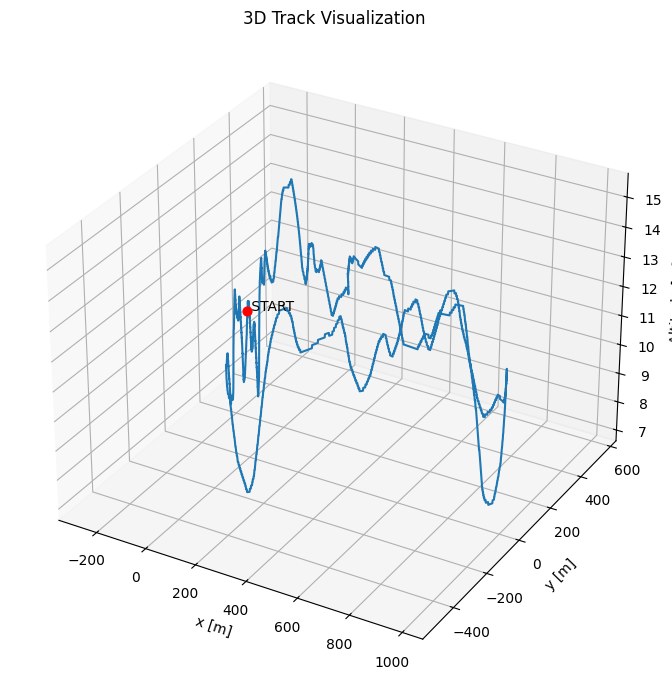

In [77]:
from mpl_toolkits.mplot3d import Axes3D
def plot_track(track: Track, show_start=True):

    plt.figure(figsize=(6, 6))
    plt.plot(track.x_m, track.y_m, linewidth=1.5)

    if show_start:
        plt.scatter(track.x_m[0], track.y_m[0], color="red")
        plt.text(track.x_m[0], track.y_m[0], " START", fontsize=8)

    plt.gca().set_aspect("equal", "box")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Lusail Track Centerline")
    plt.grid(True)
    plt.show()

def plot_track_altitude(track: Track):
    """
    Plot altitude vs distance along track.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(track.s_m, track.altitude_m, linewidth=1.5)
    plt.xlabel("Distance along track [m]")
    plt.ylabel("Altitude [m]")
    plt.title("Altitude Profile of Track")
    plt.grid(True)
    plt.show()


def plot_track_3d(track: Track):
    """
    3D visualization of track centerline using (x, y, altitude).
    """
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot3D(track.x_m, track.y_m, track.altitude_m, linewidth=1.5)

    # Mark start
    ax.scatter(track.x_m[0], track.y_m[0], track.altitude_m[0], color="red", s=40)
    ax.text(track.x_m[0], track.y_m[0], track.altitude_m[0], " START")

    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("Altitude [m]")
    ax.set_title("3D Track Visualization")
    plt.tight_layout()
    plt.show()

track = load_track_from_csv("/content/sem_apme_2025-track_coordinates.csv")

plot_track(track)               # 2D x–y
plot_track_altitude(track)      # 2D altitude vs distance
plot_track_3d(track)            # 3D track with terrain


# Car: Configuration Simulation

In [78]:
car_config = {
    # Geometry
    "mass_kg": 90.0,
    "wheel_radius_m": 0.1778,
    "gear_ratio": 5.0,
    "wheelbase_m": 1.2,       # you can adjust later
    "max_steer_deg": 25.0,

    # Motor / drivetrain
    "max_motor_rpm": 2500.0,
    "peak_torque_Nm": 10.0,   # placeholder
    "drivetrain_eff": 0.85,
    "max_throttle": 0.8,

    # Aero / rolling
    "Cd": 0.2,
    "A": 0.3,
    "Crr": 0.003,
    "air_density": 1.225,

    # Battery
    "battery_Wh": 960.0,
}

# full 2D bicycle model state
state = {
    "x": 0.0,          # world x [m]
    "y": 0.0,          # world y [m]
    "yaw": 0.0,        # heading [rad]
    "v": 0.0,          # speed [m/s]
    "s": 0.0,          # distance along track [m]
    "ey": 0.0,         # lateral deviation from track centerline [m]
    "soc": 1.0,        # battery state-of-charge (0–1)
}

control = {
    "throttle": 0.0,   # 0 to max_throttle
    "steer": 0.0       # steering command [rad]
}


In [79]:
def simulate_vehicle_step(state, control, track, cfg, dt):
    """
    Full 2D bicycle model + energy + battery + track coordinates.
    """

    # ----------------------------
    # 1. Extract variables
    # ----------------------------
    x = state["x"]
    y = state["y"]
    yaw = state["yaw"]
    v = state["v"]
    s = state["s"]
    ey = state["ey"]
    soc = state["soc"]

    throttle = np.clip(control["throttle"], 0.0, cfg["max_throttle"])
    steer = np.clip(control["steer"],
                    -np.deg2rad(cfg["max_steer_deg"]),
                    np.deg2rad(cfg["max_steer_deg"]))

    # ----------------------------
    # 2. Track reference geometry
    # ----------------------------
    x_ref, y_ref, psi_ref, curvature_ref, slope_ref = get_track_props(track, s)

    # heading difference between car and track
    yaw_error = yaw - psi_ref

    # ----------------------------
    # 3. Motor model & forces
    # ----------------------------
    # wheel angular speed
    wheel_omega = v / cfg["wheel_radius_m"]

    # motor rpm
    motor_rpm = wheel_omega * cfg["gear_ratio"] * 9.549296585  # 60/(2π)

    # simple torque curve (placeholder)
    if motor_rpm < cfg["max_motor_rpm"]:
        torque = cfg["peak_torque_Nm"] * throttle * (1 - motor_rpm / cfg["max_motor_rpm"])
    else:
        torque = 0.0

    # drivetrain → force at wheels
    F_drive = (torque * cfg["gear_ratio"] * cfg["drivetrain_eff"]) / cfg["wheel_radius_m"]

    # aero drag
    F_drag = 0.5 * cfg["air_density"] * cfg["Cd"] * cfg["A"] * v**2

    # rolling resistance
    F_roll = cfg["mass_kg"] * 9.81 * cfg["Crr"]

    # slope resistance (gravity component)
    # slope_ref is Δz/Δs → approx = sin(grade)
    F_slope = cfg["mass_kg"] * 9.81 * slope_ref

    # total longitudinal acceleration
    F_total = F_drive - F_drag - F_roll - F_slope
    a = F_total / cfg["mass_kg"]

    # ----------------------------
    # 4. Update motion (bicycle model)
    # ----------------------------
    L = cfg["wheelbase_m"]

    # yaw rate
    yaw_dot = v / L * np.tan(steer)

    # update velocity
    v_next = max(0.0, v + a * dt)

    # update yaw
    yaw_dot = v / cfg["wheelbase_m"] * np.tan(steer)
    yaw_next = yaw + yaw_dot * dt


    # update global position
    x_next = x + v_next * np.cos(yaw_next) * dt
    y_next = y + v_next * np.sin(yaw_next) * dt

    # ----------------------------
    # 5. Update track-relative variables
    # ----------------------------

    # advance along track
    ds = v_next * np.cos(yaw_error) * dt
    s_next = s + ds

    # update lateral error
    dey = v_next * np.sin(yaw_error) * dt
    ey_next = ey + dey

    # ----------------------------
    # 6. Energy model & SOC update
    # ----------------------------
    # mechanical power at wheel
    P_mech = F_drive * v_next

    # electrical power (simple model)
    if cfg["drivetrain_eff"] > 0:
        P_elec = P_mech / cfg["drivetrain_eff"]
    else:
        P_elec = 0

    # Wh consumed during dt
    energy_used_Wh = (P_elec * dt) / 3600.0

    soc_next = soc - (energy_used_Wh / cfg["battery_Wh"])
    soc_next = max(0.0, soc_next)

    # ----------------------------
    # 7. Return next state
    # ----------------------------
    return {
        "x": x_next,
        "y": y_next,
        "yaw": yaw_next,
        "v": v_next,
        "s": s_next,
        "ey": ey_next,
        "soc": soc_next,
    }


In [80]:
def run_simulation(track, cfg,
                   throttle_command=0.4,
                   k_steer=2.0,
                   dt=0.05):
    """
    Runs a full 4-lap simulation using the 2D bicycle model.
    Returns the full log and final state.
    """

    # ------------------------------------
    # INITIAL STATE
    # ------------------------------------
    state = {
        "x": track.x_m[0],
        "y": track.y_m[0],
        "yaw": track.heading_rad[0],
        "v": 0.0,
        "s": 0.0,
        "ey": 0.0,
        "soc": 1.0,
    }

    # total distance for 4 laps
    target_distance = 4 * track.length_m

    # max time = 30 minutes (SEM rules)
    max_time = 1800.0

    # ------------------------------------
    # LOGGING
    # ------------------------------------
    log = {
        "time": [],
        "x": [],
        "y": [],
        "yaw": [],
        "v": [],
        "s": [],
        "ey": [],
        "soc": [],
        "throttle": [],
        "steer": [],
        "slope": [],
    }

    # ------------------------------------
    # SIMULATION LOOP
    # ------------------------------------
    t = 0.0
    while t < max_time and state["s"] < target_distance and state["soc"] > 0:

        # track reference based on current position
        _, _, psi_ref, _, slope_ref = get_track_props(track, state["s"])

        # simple steering controller: track-heading following
        control = mpc_solve_step(state, track, cfg, dt=dt, H=10, K=300)

        # steer_cmd = k_steer * (psi_ref - state["yaw"])
        # # control input
        # control = {
        #     "throttle": throttle_command,
        #     "steer": steer_cmd
        # }

        # propagate dynamics
        state = simulate_vehicle_step(state, control, track, cfg, dt)

        # ------------------------------------
        # LOG DATA
        # ------------------------------------
        log["time"].append(t)
        log["x"].append(state["x"])
        log["y"].append(state["y"])
        log["yaw"].append(state["yaw"])
        log["v"].append(state["v"])
        log["s"].append(state["s"])
        log["ey"].append(state["ey"])
        log["soc"].append(state["soc"])
        log["throttle"].append(throttle_command)
        log["slope"].append(slope_ref)
        log.setdefault("throttle", []).append(control["throttle"])
        log.setdefault("steer", []).append(control["steer"])


        # increment time
        t += dt

    # ------------------------------------
    # SUMMARY OUTPUT
    # ------------------------------------
    print("=== Simulation Complete ===")
    print(f"Time elapsed: {t:.1f} sec")
    print(f"Distance traveled: {state['s']:.1f} m")
    print(f"Laps completed: {state['s']/track.length_m:.2f}")
    print(f"SOC remaining: {state['soc']*100:.2f}%")

    return log, state


In [81]:
def animate_car_with_telemetry(log, track, cfg):
    plt.figure(figsize=(7,7))

    # Preload arrays for speed, slope, etc.
    s_values = np.array(log["s"])
    v_values = np.array(log["v"])
    throttle_values = np.array(log.get("throttle", [0]*len(s_values)))
    steer_values = np.array(log.get("steer", [0]*len(s_values)))

    # compute slope/grade (%) along the entire log
    slope_values = np.interp(s_values % track.length_m, track.s_m, track.grade) * 100.0

    for i in range(0, len(log["x"]), 50):  # skip frames for speed

        plt.clf()

        # --- Track centerline ---
        plt.plot(track.x_m, track.y_m, 'k--', linewidth=1, label="Track")

        # --- Car trajectory up to current time ---
        plt.plot(log["x"][:i], log["y"][:i], 'b-', linewidth=1.2, label="Car path")

        # --- Current car position ---
        plt.scatter(log["x"][i], log["y"][i], color='red', s=40)

        # --- Telemetry text block ---
        speed_kmh = v_values[i] * 3.6
        throttle_pct = throttle_values[i] * 100
        steer_deg = np.rad2deg(steer_values[i])
        slope_pct = slope_values[i]

        telemetry = (
            f"Time: {log['time'][i]:.1f} s\n"
            f"Speed: {speed_kmh:.1f} km/h\n"
            f"Throttle: {throttle_pct:.1f}%\n"
            f"Steer: {steer_deg:.1f}°\n"
            f"Slope: {slope_pct:.2f}%"
        )

        plt.text(
            0.02, 0.98, telemetry,
            transform=plt.gca().transAxes,
            fontsize=10, family='monospace',
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

        # --- Plot formatting ---
        plt.title("Car Simulation with Telemetry")
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.gca().set_aspect("equal", "box")
        plt.grid(True)

        plt.pause(0.001)

    plt.show()

def plot_simulation_metrics(log):
    time = np.array(log["time"])
    v = np.array(log["v"])
    throttle = np.array(log["throttle"])
    steer = np.array(log["steer"])
    slope = np.array(log["slope"])

    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    # ---- 1. Speed ----
    axs[0].plot(time, v, label="Speed (m/s)", color='b')
    axs[0].set_ylabel("Speed (m/s)")
    axs[0].grid(True)
    axs[0].set_title("Vehicle Speed, Throttle, Steering, and Track Slope")

    # ---- 2. Throttle ----
    axs[1].plot(time, throttle, label="Throttle", color='g')
    axs[1].set_ylabel("Throttle")
    axs[1].set_ylim([-0.05, 1.0])
    axs[1].grid(True)

    # ---- 3. Steering ----
    axs[2].plot(time, steer, label="Steer (rad)", color='orange')
    axs[2].set_ylabel("Steer (rad)")
    axs[2].grid(True)

    # ---- 4. Slope (secondary axis) ----
    ax4 = axs[3]
    ax4.plot(time, slope, label="Slope (grade)", color='purple')
    ax4.set_ylabel("Slope (m/m)")
    ax4.grid(True)

    # Secondary y-axis with slope in percent
    ax4b = ax4.twinx()
    ax4b.plot(time, slope * 100, color='red', alpha=0.4)
    ax4b.set_ylabel("Slope (%)")

    axs[3].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


In [82]:
log, final_state = run_simulation(track, car_config)
# animate_car_with_telemetry(log, track, car_config)
# plot_simulation_metrics(log)


=== Simulation Complete ===
Time elapsed: 1662.7 sec
Distance traveled: 14704.4 m
Laps completed: 4.00
SOC remaining: 96.93%


In [126]:
# !pip install casadi

In [127]:
import casadi as ca
import numpy as np


def build_mpc_solver(track, cfg, N=20, dt=0.1):
    """
    Fully CasADi-safe MPC with NO symbolic iteration.
    """

    nx = 5   # [s, ey, v, psi, soc]
    nu = 2   # [throttle, steer]

    # ============================================================
    # 1) Define symbolic variables
    # ============================================================
    X = ca.MX.sym("X", nx, N+1)    # states over horizon
    U = ca.MX.sym("U", nu, N)      # control trajectory
    Z = ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1))

    # ============================================================
    # 2) Interpolants (track)
    # ============================================================
    psi_ref   = ca.interpolant('psi',   'linear', [track.s_m], track.heading_rad)
    curv_ref  = ca.interpolant('curv',  'linear', [track.s_m], track.curvature)
    grade_ref = ca.interpolant('grade', 'linear', [track.s_m], track.grade)

    # ============================================================
    # 3) Dynamics function f(x,u)
    # ============================================================
    x_sym = ca.MX.sym("x", nx)
    u_sym = ca.MX.sym("u", nu)

    def f_dynamics(x, u):
        s, ey, v, psi, soc = x
        throttle, steer = u

        steer = ca.fmax(ca.fmin(steer, np.deg2rad(cfg["max_steer_deg"])),
                        -np.deg2rad(cfg["max_steer_deg"]))

        # Track lookups
        psi_r = psi_ref(s % track.length_m)
        curv  = curv_ref(s % track.length_m)
        grade = grade_ref(s % track.length_m)

        # Motor + longitudinal forces
        wheel_omega = v / cfg["wheel_radius_m"]
        motor_rpm = wheel_omega * cfg["gear_ratio"] * 60 / (2*np.pi)
        torque = cfg["peak_torque_Nm"] * throttle * (1 - motor_rpm/cfg["max_motor_rpm"])
        torque = ca.fmax(torque, 0)

        F_drive = (torque * cfg["gear_ratio"] * cfg["drivetrain_eff"]) / cfg["wheel_radius_m"]
        F_drag = 0.5 * cfg["air_density"] * cfg["Cd"] * cfg["A"] * v*v
        F_roll = cfg["mass_kg"] * 9.81 * cfg["Crr"]
        F_slope = cfg["mass_kg"] * 9.81 * grade

        a = (F_drive - F_drag - F_roll - F_slope) / cfg["mass_kg"]

        L = cfg["wheelbase_m"]

        # Track-relative bicycle model
        psi_dot = v/L * ca.tan(steer) - curv*v
        s_dot = v * ca.cos(psi)
        ey_dot = v * ca.sin(psi)

        P_mech = F_drive * v
        P_elec = P_mech / cfg["drivetrain_eff"]
        soc_dot = -(P_elec * dt) / (3600 * cfg["battery_Wh"])

        return ca.vertcat(s_dot, ey_dot, a, psi_dot, soc_dot)

    f = ca.Function("f", [x_sym, u_sym], [f_dynamics(x_sym, u_sym)])

    # ============================================================
    # 4) Build dynamic constraints vector G
    # ============================================================

    G = []

    for k in range(N):      # <-- Python loop OK (X[:,k] is MX element, NOT iterable)
        xk = X[:, k]
        uk = U[:, k]
        x_next = X[:, k+1]

        x_pred = xk + dt * f(xk, uk)
        G.append(x_next - x_pred)

    G = ca.vertcat(*G)

    # ============================================================
    # 5) Cost function
    # ============================================================
    cost = 0

    for k in range(N):      # Python loop OK
        ey  = X[1, k]
        psi = X[3, k]
        v   = X[2, k]

        cost += 5.0 * ey*ey
        cost += 2.0 * psi*psi
        cost += 0.5 * (v - 5.0)**2     # 5 m/s target speed
        cost += 0.1 * U[0,k]**2        # throttle penalty
        cost += 1.0 * U[1,k]**2        # steering penalty

    # ============================================================
    # 6) Solver
    # ============================================================
    nlp = {"x": Z, "f": cost, "g": G}

    solver = ca.nlpsol("solver", "ipopt", nlp, {
        "ipopt.print_level": 0,
        "print_time": False,
    })

    # bounds
    Z_lb = -1e9*np.ones(Z.shape[0])
    Z_ub =  1e9*np.ones(Z.shape[0])

    # control bounds override
    offset = nx*(N+1)
    for k in range(N):
        Z_lb[offset + 2*k]   = 0.0                        # throttle min
        Z_ub[offset + 2*k]   = cfg["max_throttle"]        # throttle max

        Z_lb[offset + 2*k+1] = -np.deg2rad(cfg["max_steer_deg"])
        Z_ub[offset + 2*k+1] =  np.deg2rad(cfg["max_steer_deg"])

    g_lb = np.zeros(G.shape[0])
    g_ub = np.zeros(G.shape[0])

    # ============================================================
    # 7) MPC evaluation function
    # ============================================================

    def solve_mpc(state):
        z0 = np.zeros(Z.shape[0])

        sol = solver(
            x0=z0,
            lbx=Z_lb,
            ubx=Z_ub,
            lbg=g_lb,
            ubg=g_ub
        )

        z_opt = sol["x"].full().flatten()

        # first U = optimal control
        throttle_cmd = z_opt[offset]
        steer_cmd    = z_opt[offset+1]

        return float(throttle_cmd), float(steer_cmd)

    return solve_mpc


In [128]:
# solve_mpc = build_mpc_solver(track, car_config)

# throttle_cmd, steer_cmd = solve_mpc(state)


## Random Shooting

In [148]:
def mpc_cost(traj, control_seq, track, cfg):
    J = 0.0

    # speed limits in m/s
    v_min = 8.33     # 30 km/h
    v_max = 11.11    # 40 km/h

    for k in range(len(traj)):
        st = traj[k]
        u = control_seq[k]

        psi_ref = np.interp(st["s"] % track.length_m, track.s_m, track.heading_rad)
        psi_err = st["yaw"] - psi_ref

        v = st["v"]

        # ---------------------------------------------------
        # 🔥 ENERGY SURROGATE
        P = v * v
        J_energy = 1.0 * P / max(0.3, v)

        # ---------------------------------------------------
        # 🔥 LATERAL ERROR
        J_lat = 10.0 * (st["ey"] ** 2)

        # ---------------------------------------------------
        # 🔥 HEADING ERROR
        J_head = 5.0 * (psi_err ** 2)

        # ---------------------------------------------------
        # 🔥 SPEED-WINDOW PENALTY
        if v < v_min:
            # too slow (BIG penalty)
            J_speed = 50.0 * (v_min - v) ** 2
        elif v > v_max:
            # too fast (even BIGGER penalty)
            J_speed = 80.0 * (v - v_max) ** 2
        else:
            # in the sweet spot
            J_speed = 0.0

        # ---------------------------------------------------
        # 🔥 CONTROL SMOOTHNESS
        if k > 0:
            du_t = control_seq[k][0] - control_seq[k-1][0]
            du_s = control_seq[k][1] - control_seq[k-1][1]
            J_smooth = 2.0 * (du_t**2 + du_s**2)
        else:
            J_smooth = 0.0

        # ---------------------------------------------------
        # TOTAL COST
        J += J_energy + J_lat + J_head + J_speed + J_smooth

    return J


def mpc_solve_step(state, track, cfg, dt=0.1, H=10, K=300):
    best_cost = float("inf")
    best_action = (0.0, 0.0)

    throttle_max = cfg["max_throttle"]
    steer_max = np.deg2rad(cfg["max_steer_deg"])

    for _ in range(K):

        # sample a random control sequence
        control_seq = []
        for t in range(H):
            thr = np.random.uniform(0, throttle_max)
            ste = np.random.uniform(-steer_max, steer_max)
            control_seq.append((thr, ste))

        # simulate forward this sequence
        st = state.copy()
        traj = []
        for (thr, ste) in control_seq:
            control = {"throttle": thr, "steer": ste}
            st = simulate_vehicle_step(st, control, track, cfg, dt)
            traj.append(st)

        # evaluate cost
        J = mpc_cost(traj, control_seq, track, cfg)

        # update best
        if J < best_cost:
            best_cost = J
            best_action = control_seq[0]

    return {"throttle": best_action[0], "steer": best_action[1]}

def run_mpc_simulation(track, cfg, dt=0.1):
    state = {
        "x": track.x_m[0],
        "y": track.y_m[0],
        "yaw": track.heading_rad[0],
        "v": 0.0,
        "s": 0.0,
        "ey": 0.0,
        "soc": 1.0,
    }

    total_distance = 4 * track.length_m
    t = 0.0
    max_time = 1800.0  # 30 minutes safety timeout

    log = { "time": [], "x": [], "y": [], "v": [], "s": [], "yaw": [], "ey": [], "soc": [], "throttle": [], "steer": [] }

    while state["s"] < total_distance:

        # ⚠️ safety warnings (NOT stopping conditions)
        if t > max_time:
            print(f"⚠️ WARNING t={t:.1f}s: exceeded 30 min, forcing limp mode.")
        if state["soc"] <= 0:
            print(f"⚠️ WARNING t={t:.1f}s: SOC depleted, using limp throttle.")
            limp_throttle = 0.05
            control = {"throttle": limp_throttle, "steer": 0.0}
        else:
            # MPC chooses the next control
            control = mpc_solve_step(state, track, cfg, dt=dt, H=10, K=200)

        # debug every 500 steps
        if int(t/dt) % 500 == 0:
            print(f"[t={t:.1f}s] MPC → thr={control['throttle']:.3f}, "
                  f"steer={np.rad2deg(control['steer']):.2f}°, "
                  f"v={state['v']:.2f} m/s, ey={state['ey']:.2f}, "
                  f"s={state['s']:.1f}, soc={state['soc']:.3f}")

        # simulate forward
        state = simulate_vehicle_step(state, control, track, cfg, dt)

        # log
        log["time"].append(t)
        log["x"].append(state["x"])
        log["y"].append(state["y"])
        log["v"].append(state["v"])
        log["s"].append(state["s"])
        log["yaw"].append(state["yaw"])
        log["ey"].append(state["ey"])
        log["soc"].append(state["soc"])
        log["throttle"].append(control["throttle"])
        log["steer"].append(control["steer"])

        t += dt

    print("\nMPC Simulation finished:")
    print(f"  Time:              {t:.1f} sec (may exceed 30 min)")
    print(f"  SOC remaining:     {state['soc']*100:.1f}%")
    print(f"  Laps completed:    {state['s']/track.length_m:.2f}")

    return log, state


In [ ]:
log, final_state = run_mpc_simulation(track, car_config)


Streaming output truncated to the last 5000 lines.
⚠️ WARNING t=10417.4s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10417.5s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10417.6s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10417.7s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10417.8s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10417.9s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.0s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.1s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.2s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.3s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.4s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.5s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.6s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.7s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.8s: exceeded 30 min, forcing limp mode.
⚠️ WARNING t=10418.9s: exceeded 30 min, forcing limp mode.
⚠️ WA

## MCP: Finding best driving style

In [83]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange


In [113]:
import torch
print("Torch CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.current_device() if torch.cuda.is_available() else "none")


Torch CUDA available: True
CUDA device: 0


In [114]:
device = torch.device("cuda")

track.s_gpu     = torch.tensor(track.s_m,         dtype=torch.float32, device=device)
track.psi_gpu   = torch.tensor(track.heading_rad, dtype=torch.float32, device=device)
track.grade_gpu = torch.tensor(track.grade,       dtype=torch.float32, device=device)
track.length_m_gpu = torch.tensor(track.length_m, dtype=torch.float32, device=device)



In [115]:
def interp1d_torch(x, xp, fp):
    """
    Fully GPU-accelerated 1D linear interpolation.
    x, xp, fp must be CUDA tensors.
    """
    # clamp range
    x = x.clamp(xp[0], xp[-1])

    inds = torch.searchsorted(xp, x)
    inds = inds.clamp(1, len(xp)-1)

    x0 = xp[inds - 1]
    x1 = xp[inds]
    f0 = fp[inds - 1]
    f1 = fp[inds]

    return f0 + (f1 - f0) * (x - x0) / (x1 - x0 + 1e-9)



def vehicle_dynamics_torch(state, control, track, cfg, dt):
    """
    Track-relative bicycle model on GPU.
    state = [s, ey, yaw_err, v, soc]
    control = [throttle, steer]
    """

    s, ey, yaw_err, v, soc = state[...,0], state[...,1], state[...,2], state[...,3], state[...,4]
    throttle, steer = control[...,0], control[...,1]

    # BOUNDS
    max_steer = torch.deg2rad(torch.tensor(cfg["max_steer_deg"], dtype=torch.float32, device=steer.device))
    steer = steer.clamp(-max_steer, max_steer)
    throttle = throttle.clamp(0.0, cfg["max_throttle"])


    # TRACK INTERPOLATION (GPU)
    s_mod = torch.remainder(s, track.length_m_gpu)

    psi_ref = interp1d_torch(s_mod, track.s_gpu, track.psi_gpu)
    slope   = interp1d_torch(s_mod, track.s_gpu, track.grade_gpu)

    # FORCES
    wheel_omega = v / cfg["wheel_radius_m"]
    motor_rpm = wheel_omega * cfg["gear_ratio"] * 60 / (2*torch.pi)
    torque = cfg["peak_torque_Nm"] * throttle * (1 - (motor_rpm / cfg["max_motor_rpm"]).clamp(0,1))
    F_drive = torque * cfg["gear_ratio"] * cfg["drivetrain_eff"] / cfg["wheel_radius_m"]
    F_drag  = 0.5 * cfg["air_density"] * cfg["Cd"] * cfg["A"] * v*v
    F_roll  = cfg["mass_kg"] * 9.81 * cfg["Crr"]
    F_grade = cfg["mass_kg"] * 9.81 * slope

    a = (F_drive - F_drag - F_roll - F_grade) / cfg["mass_kg"]
    v_next = (v + a * dt).clamp(min=0.0)

    # YAW ABS → ERROR UPDATE
    L = cfg["wheelbase_m"]
    yaw_dot = v * torch.tan(steer) / L

    # absolute yaw (relative to track)
    yaw_abs = psi_ref + yaw_err
    yaw_abs_next = yaw_abs + yaw_dot * dt

    # TRACK INTERPOLATION FOR NEXT STEP
    s_next = s + v * torch.cos(yaw_err) * dt
    s_mod_next = torch.remainder(s_next, track.length_m_gpu)
    psi_ref_next = interp1d_torch(s_mod_next, track.s_gpu, track.psi_gpu)

    yaw_err_next = yaw_abs_next - psi_ref_next
    ey_next = ey + v * torch.sin(yaw_err) * dt

    # SOC UPDATE
    P_mech = F_drive * v
    P_elec = P_mech / cfg["drivetrain_eff"]
    soc_next = (soc - (P_elec * dt / 3600.0) / cfg["battery_Wh"]).clamp(min=0.0)

    return torch.stack([s_next, ey_next, yaw_err_next, v_next, soc_next], dim=-1)


def mpc_cost(states, controls, track, cfg):
    xs = states[1:]
    us = controls

    s   = xs[:,0]
    ey  = xs[:,1]
    yaw = xs[:,2]
    v   = xs[:,3]
    soc = xs[:,4]

    throttle = us[:,0]
    steer    = us[:,1]

    # 1. Track following
    cost_ey   = 4.0 * ey**2
    cost_yaw  = 2.0 * yaw**2

    # 2. Speed target
    speed_target = 2.0
    cost_speed = 0.2 * (v - speed_target)**2

    # 3. Energy cost
    cost_energy = 0.5 * throttle**2

    # 4. Progress reward
    ds = states[1:,0] - states[:-1,0]
    progress = -25.0 * ds

    # 5. Smoothness
    dth = torch.diff(throttle, prepend=throttle[:1])
    dst = torch.diff(steer,    prepend=steer[:1])
    cost_smooth = 0.1 * (dth**2 + dst**2)

    # 6. Startup force (CRITICAL)
    cost_start = 30.0 * (0.8 - v).clamp(min=0)**2

    return (cost_ey + cost_yaw + cost_speed + cost_energy +
            cost_smooth + cost_start + progress).sum()




def solve_mpc(state, track, cfg, H=20, dt=0.1, iters=60):
    device = track.s_gpu.device  # ensure same device

    # compute yaw error
    psi_ref0 = get_track_props(track, state["s"])[2]
    yaw_abs0 = state["yaw"]               # world yaw
    yaw_err0 = yaw_abs0 - psi_ref0        # relative heading


    s_init = torch.tensor([state["s"], state["ey"], yaw_err0, state["v"], state["soc"]],
                           dtype=torch.float32, device=device)

    u = torch.zeros((H,2), dtype=torch.float32, device=device, requires_grad=True)
    opt = torch.optim.Adam([u], lr=0.05)

    for i in range(iters):
        opt.zero_grad()

        x = s_init
        xs = [x]

        for t in range(H):
            x = vehicle_dynamics_torch(x, u[t], track, cfg, dt)
            xs.append(x)

        xs = torch.stack(xs, dim=0)
        cost = mpc_cost(xs, u, track, cfg)

        cost.backward()
        opt.step()
        print("iter", i, "cost =", float(cost))

    u0 = u[0].detach().cpu().numpy()
    return {"throttle": float(u0[0]), "steer": float(u0[1])}


In [111]:
def run_mpc_simulation(track, cfg, H=20, dt=0.1, iters=30, p=5000):
    state = {
        "x": track.x_m[0],
        "y": track.y_m[0],
        "yaw": track.heading_rad[0] + 0.05 ,
        "v": 0.0,
        "s": 0.0,
        "ey": 0.0,
        "soc": 1.0,
    }

    total_distance = 4 * track.length_m

    log = {k: [] for k in ["time","x","y","yaw","v","s","ey","soc","throttle","steer"]}

    t = 0
    pbar = trange(0, int(p))

    for _ in pbar:
        # MPC decision
        control = solve_mpc(state, track, cfg, H=H, dt=dt, iters=iters)

        # Apply the action to REAL simulator
        state = simulate_vehicle_step(state, control, track, cfg, dt)

        # log
        log["time"].append(t)
        log["x"].append(state["x"])
        log["y"].append(state["y"])
        log["yaw"].append(state["yaw"])
        log["v"].append(state["v"])
        log["s"].append(state["s"])
        log["ey"].append(state["ey"])
        log["soc"].append(state["soc"])
        log["throttle"].append(control["throttle"])
        log["steer"].append(control["steer"])

        t += dt

        if state["s"] >= total_distance:
            break
        if state["soc"] <= 0:
            break

    return log, state


In [116]:
# === QUICK GPU MPC TEST ===

# 1) Verify track tensors exist
print("track.s_gpu device =", track.s_gpu.device)
print("track.psi_gpu device =", track.psi_gpu.device)
print("track.grade_gpu device =", track.grade_gpu.device)

# 2) Minimal initial state (world coords)
state_test = {
    "s": 0.0,
    "ey": 0.0,
    "yaw": track.heading_rad[0] + 0.05,   # force small yaw error
    "v": 0.0,
    "soc": 1.0
}

psi0 = get_track_props(track, state_test["s"])[2]
print("world yaw =", state_test["yaw"])
print("track psi =", psi0)
print("yaw_err0  =", state_test["yaw"] - psi0)


print("\nRunning ONE MPC solve...")

u = solve_mpc(state_test, track, car_config, H=12, dt=0.2, iters=40)

print("\n=== MPC OUTPUT ===")
print(u)

# 3) Apply the MPC action to a single step of the real simulator
step = simulate_vehicle_step(
    {"x": 0, "y": 0, "yaw": track.heading_rad[0], "v": 0.0, "s": 0.0, "ey": 0.0, "soc": 1.0},
    u,
    track,
    car_config,
    dt=0.2
)

print("\n=== NEXT STATE AFTER APPLYING CONTROL ===")
print(step)


track.s_gpu device = cuda:0
track.psi_gpu device = cuda:0
track.grade_gpu device = cuda:0
world yaw = 2.067127749272748
track psi = 2.017127749272748
yaw_err0  = 0.04999999999999982

Running ONE MPC solve...
iter 0 cost = 240.0600128173828
iter 1 cost = 240.0600128173828
iter 2 cost = 240.0600128173828
iter 3 cost = 240.0600128173828
iter 4 cost = 240.0600128173828
iter 5 cost = 240.0600128173828
iter 6 cost = 240.0600128173828
iter 7 cost = 240.0600128173828
iter 8 cost = 240.0600128173828
iter 9 cost = 240.0600128173828
iter 10 cost = 240.0600128173828
iter 11 cost = 240.0600128173828
iter 12 cost = 240.0600128173828
iter 13 cost = 240.0600128173828
iter 14 cost = 240.0600128173828
iter 15 cost = 240.0600128173828
iter 16 cost = 240.0600128173828
iter 17 cost = 240.0600128173828
iter 18 cost = 240.0600128173828
iter 19 cost = 240.0600128173828
iter 20 cost = 240.0600128173828
iter 21 cost = 240.0600128173828
iter 22 cost = 240.0600128173828
iter 23 cost = 240.0600128173828
iter 24 co

In [89]:
psi0 = get_track_props(track, 0)[2]
print("yaw =", state_test["yaw"])
print("psi0 =", psi0)
print("yaw_err0 =", state_test["yaw"] - psi0)


yaw = 2.067127749272748
psi0 = 2.017127749272748
yaw_err0 = 0.04999999999999982


In [90]:
# log, final_state = run_mpc_simulation(
#     track,
#     car_config,
#     H=12,       # bigger horizon
#     iters=40,   # more optimization steps
#     dt=0.2,
#     p=500       # enough cycles to see movement
# )

# animate_car_with_telemetry(log, track, car_config)

  7%|▋         | 34/500 [00:58<13:25,  1.73s/it]


KeyboardInterrupt: 

## Saving files

In [ ]:
import numpy as np

def generate_pace_notes(log, track, out_file="/content/pace_notes.txt"):
    """
    Convert raw MPC logs into human-readable driving instructions.
    """
    s_arr = np.array(log["s"])
    v_arr = np.array(log["v"])
    throttle_arr = np.array(log["throttle"])
    steer_arr = np.array(log["steer"])

    # compute curvature & slope
    curvature = np.interp(s_arr % track.length_m, track.s_m, track.curvature)
    slope = np.interp(s_arr % track.length_m, track.s_m, track.grade)

    # Open file for writing
    with open(out_file, "w") as f:
        f.write("=== Driving Instructions (Pace Notes) ===\n")
        f.write("Generated from MPC Simulation\n\n")

        segment_size = 20  # meters per instruction
        max_s = s_arr[-1]

        for start_s in np.arange(0, max_s, segment_size):
            # pick nearest index
            idx = (np.abs(s_arr - start_s)).argmin()

            speed = v_arr[idx] * 3.6
            thr = throttle_arr[idx] * 100
            st_deg = np.rad2deg(steer_arr[idx])
            curv = curvature[idx]
            slp = slope[idx] * 100

            # classify corner severity
            if abs(curv) < 0.002:
                corner = "Straight"
            elif abs(curv) < 0.008:
                corner = "Mild turn"
            else:
                corner = "Sharp turn"

            # classify slope
            if abs(slp) < 0.2:
                slope_desc = "Flat"
            elif slp > 0:
                slope_desc = "Uphill"
            else:
                slope_desc = "Downhill"

            f.write(
                f"Distance {start_s:.0f}–{start_s+segment_size:.0f} m:\n"
                f"  • {corner}, {slope_desc}\n"
                f"  • Recommended speed: {speed:.1f} km/h\n"
                f"  • Throttle: {thr:.1f}%\n"
                f"  • Steer: {st_deg:.1f}°\n\n"
            )

    print(f"Pace notes saved to {out_file}")


In [ ]:
import csv

def export_mpc_csv(log, track, out_file="/content/driving_instructions.csv"):
    """
    Save detailed MPC output to CSV:
    distance, speed, throttle, steer, slope, curvature
    """
    s_arr = np.array(log["s"])
    v_arr = np.array(log["v"])
    throttle_arr = np.array(log["throttle"])
    steer_arr = np.array(log["steer"])

    # interpolate slope & curvature
    curvature = np.interp(s_arr % track.length_m, track.s_m, track.curvature)
    slope = np.interp(s_arr % track.length_m, track.s_m, track.grade)

    with open(out_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "distance_m",
            "speed_mps",
            "speed_kph",
            "throttle_pct",
            "steer_deg",
            "slope_pct",
            "curvature"
        ])

        for i in range(len(s_arr)):
            writer.writerow([
                s_arr[i],
                v_arr[i],
                v_arr[i] * 3.6,
                throttle_arr[i] * 100,
                np.rad2deg(steer_arr[i]),
                slope[i] * 100,
                curvature[i]
            ])

    print(f"CSV instructions saved to {out_file}")


In [ ]:
generate_pace_notes(log, track, "/content/pace_notes.txt")
export_mpc_csv(log, track, "/content/driving_instructions.csv")